
# Project: LYFT 2019 Bike Ridership
Richard

In [1]:
# Import packages used.
import pandas as pd
import seaborn as sb
import numpy as np
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

# Questions:
#### 1. When are most trips taken in terms of day of the week, or month of the year?
#### 2. How long does the average trip take?
#### 3. Does the above depend on whether a user is a subscriber or customer?

# Gathering Data

In [2]:
# Extract downloaded zip files and combine them into a dataframe
files = ['201901-fordgobike-tripdata.csv.zip','201902-fordgobike-tripdata.csv.zip',
         '201903-fordgobike-tripdata.csv.zip','201904-fordgobike-tripdata.csv.zip',
        '201905-baywheels-tripdata.csv.zip','201906-baywheels-tripdata.csv.zip',
        '201907-baywheels-tripdata.csv.zip','201908-baywheels-tripdata.csv.zip',
        '201909-baywheels-tripdata.csv.zip','201910-baywheels-tripdata.csv.zip',
        '201911-baywheels-tripdata.csv.zip','201912-baywheels-tripdata.csv.zip']
df = pd.DataFrame()
for file in files:
    with zipfile.ZipFile(file, 'r') as myzip:
        myzip.extractall()
    month = pd.read_csv(file[:-4],low_memory = False)
    df = pd.concat([df,month]) 

# Assessing Data

In [3]:
df.reset_index().head()

,index,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method
0,0,80825,2019-01-31 17:57:44.6130,2019-02-01 16:24:49.8640,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037,196.0,Grand Ave at Perkins St,37.808894,-122.256460,4861,Subscriber,No,NaN
1,1,65900,2019-01-31 20:58:33.8860,2019-02-01 15:16:54.1730,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,134.0,Valencia St at 24th St,37.752428,-122.420628,5506,Subscriber,No,NaN
2,2,62633,2019-01-31 18:06:52.9240,2019-02-01 11:30:46.5300,245.0,Downtown Berkeley BART,37.870139,-122.268422,157.0,65th St at Hollis St,37.846784,-122.291376,2717,Customer,No,NaN
3,3,44680,2019-01-31 19:46:09.7190,2019-02-01 08:10:50.3180,85.0,Church St at Duboce Ave,37.770083,-122.429156,53.0,Grove St at Divisadero,37.775946,-122.437777,4557,Customer,No,NaN
4,4,60709,2019-01-31 14:19:01.5410,2019-02-01 07:10:51.0650,16.0,Steuart St at Market St,37.794130,-122.394430,28.0,The Embarcadero at Bryant St,37.787168,-122.388098,2100,Customer,No,NaN


In [4]:
# Data is mostly clean. 
# Need to drop columns and change data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2506983 entries, 0 to 150101
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration_sec             int64  
 1   start_time               object 
 2   end_time                 object 
 3   start_station_id         float64
 4   start_station_name       object 
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_name         object 
 9   end_station_latitude     float64
 10  end_station_longitude    float64
 11  bike_id                  int64  
 12  user_type                object 
 13  bike_share_for_all_trip  object 
 14  rental_access_method     object 
dtypes: float64(6), int64(2), object(7)
memory usage: 306.0+ MB


# Cleaning Data

In [5]:
# Dropped unnecessary columns and modified data types
df = df[['duration_sec','start_time','user_type']]
df['start_time'] = pd.to_datetime(df['start_time'])
df['user_type'] = df['user_type'].astype('category')
df['month'] = pd.DatetimeIndex(df['start_time']).month
df['day_of_week'] = df['start_time'].dt.dayofweek

In [6]:
# Dictionaries for month and days of week
months = {1:'January', 2:'Febuary',3:'March',4:'April',5:'May',6:'June',7:'July',
          8:'August',9:'September',10:'October',11:'November',12:'December'}
day_of_week = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday'
               ,4:'Friday',5:'Saturday',6:'Sunday'}

In [7]:
# Replace numerical values to names
df['month'].replace(months, inplace = True)
df['day_of_week'].replace(day_of_week, inplace = True)

In [8]:
# Remove extreme outlier
df = df[df['duration_sec'] != df.duration_sec.max()]

In [9]:
df.head()

,duration_sec,start_time,user_type,month,day_of_week
0,80825,2019-01-31 17:57:44.613,Subscriber,January,Thursday
1,65900,2019-01-31 20:58:33.886,Subscriber,January,Thursday
2,62633,2019-01-31 18:06:52.924,Customer,January,Thursday
3,44680,2019-01-31 19:46:09.719,Customer,January,Thursday
4,60709,2019-01-31 14:19:01.541,Customer,January,Thursday


# Exploratory Analysis

#### Duration has a log-normal distribution that peaks around 600 seconds (10 minutes)

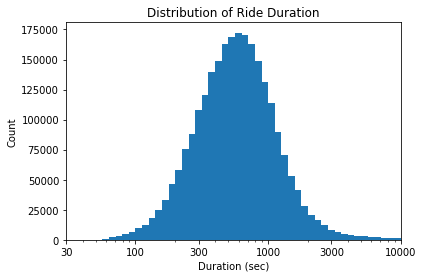

In [11]:
# Creating bin edges based on the data
bin_edges = 10**np.arange(0, np.log10(df.duration_sec.max())+0.05,0.05)
plt.hist(data = df,x = 'duration_sec',bins = bin_edges)
plt.xscale('log')
# Creating tick that are more readable
ticks = [30,100,300,1000,3000,10000,30000,100000]
plt.xticks(ticks,ticks)
plt.xlim(30,10000)
plt.title('Distribution of Ride Duration')
plt.xlabel('Duration (sec)')
plt.ylabel('Count');

In [ ]:
# Ordering data for plotting
week_order = pd.api.types.CategoricalDtype(ordered = True, categories = day_of_week.values())
df['day_of_week'] = df['day_of_week'].astype(week_order)

month_order = pd.api.types.CategoricalDtype(ordered = True, categories = months.values())
df['month']=df['month'].astype(month_order)

#### Ridership peaked in the months of March and July

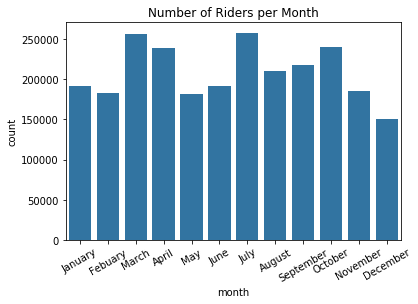

In [16]:
sb.countplot(data = df, x = 'month',color = base_color)
plt.title('Number of Riders per Month')
plt.xticks(rotation = 30);

#### There are more riders on the week days than the weekends

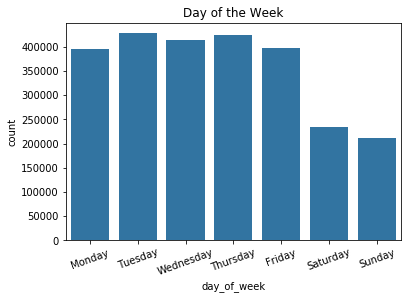

In [17]:
sb.countplot(data = df, x = 'day_of_week',color = base_color)
plt.title('Day of the Week')
plt.xticks(rotation = 20);

#### There are substantially more members (subscriber) than casual (customers) users. 

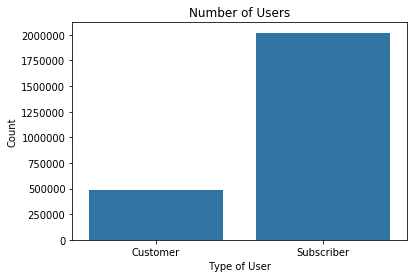

In [10]:
base_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'user_type', color = base_color)
plt.title('Number of Users')
plt.xlabel("Type of User")
plt.ylabel('Count');

#### Duration of rides are longer on the weekend when compared to weekdays

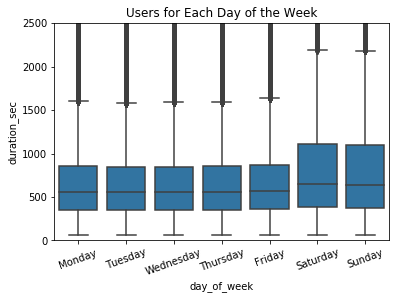

In [21]:
sb.boxplot(data = df, x = 'day_of_week', y = 'duration_sec', color = base_color)
plt.ylim(0,2500)
plt.title('Users for Each Day of the Week')
plt.xticks(rotation = 20);

#### Number of subscribers went down significantly in December. Number of customers went up.

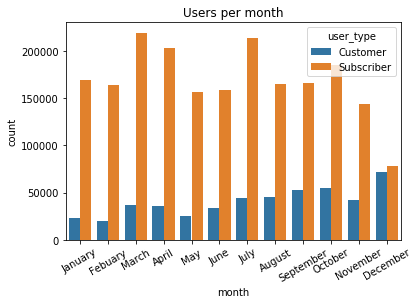

In [20]:
sb.countplot(data = df, x = 'month',hue = 'user_type')
plt.title('Users per month')
plt.xticks(rotation = 30);